# Explore RoutineImmunization

In [1]:
import numpy as np
from laser.core import __version__ as laser_core_version
from laser.generic import __version__ as laser_generic_version
from laser.generic import SEIR
from laser.generic import Model
from laser.generic.vitaldynamics import BirthsByCBR, MortalityByEstimator
from laser.core.utils import grid
from laser.core import PropertySet
from laser.core import distributions
from laser.generic.newutils import ValuesMap
from laser.core.demographics import load_pyramid_csv
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator

POPULATION = 200_000
INITIAL_INFECTIONS = 100
ROWS = 1
COLS = 1
NNODES = ROWS * COLS

scenario = grid(M=ROWS, N=COLS, population_fn=lambda x, y: POPULATION // NNODES)
scenario["S"] = scenario.population - INITIAL_INFECTIONS
scenario["E"] = 0
scenario["I"] = INITIAL_INFECTIONS
scenario["R"] = 0

R0 = 7 # 1.125
exposure_mean = 7.0
exposure_scale = 1.0
infectious_mean = 10.0
infectious_scale = 1.5
beta = R0 / infectious_mean

NTICKS = 730
parameters = PropertySet({"nticks": NTICKS, "beta": beta})
birthrates = ValuesMap.from_scalar(35.0, NNODES, NTICKS)

expdurdist = distributions.normal(loc=exposure_mean, scale=exposure_scale)
infdurdist = distributions.normal(loc=infectious_mean, scale=infectious_scale)

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Population WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx
age_data = np.loadtxt("Nigeria-Distribution-2020.csv", delimiter=",", usecols=0)[0:89]  # Up to age 89 (largest value int16 can hold.)
pyramid = AliasedDistribution(age_data)

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Mortality WPP2024_MORT_F04_1_LIFE_TABLE_SURVIVORS_BOTH_SEXES.xlsx
survival_data = np.loadtxt("Nigeria-Survival-2020.csv", delimiter=",", usecols=1)[0:89].cumsum() # Up to age 89 (largest value int16 can hold.)
survival = KaplanMeierEstimator(survival_data)

print(f"laser-core version: {laser_core_version}")
print(f"laser-generic version: {laser_generic_version}")


laser-core version: 0.7.0
laser-generic version: 0.0.0


In [2]:
import matplotlib.pyplot as plt

def plot_traces(model, zoom=1.0, style=["-", "--"]):
    figure = plt.figure(figsize=(zoom*6, zoom*4.5))
    axes = [figure.add_subplot(1, 1, 1)]
    axes.append(axes[0].twinx())

    for channel, axis, color in [('S', 0, "blue"), ('E', 1, "orange"), ('I', 1, "red"), ('R', 0, "green")]:
        for node in range(model.nodes.count):
            data = getattr(model.nodes, channel)[:,node]
            label = f"Node {node} - {channel}"
            axes[axis].plot(data, label=label, color=color, linestyle=style[node % len(style)])

    axes[0].set_xlabel("Time (days)")
    axes[0].set_ylabel("Population")
    axes[1].set_ylabel("Population")
    axes[0].legend(loc="upper left")
    axes[1].legend(loc="upper right")
    axes[0].grid(True, which="both", axis="both", linestyle=":", linewidth=0.7, alpha=0.7, color="purple")
    axes[1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.7, alpha=0.7, color="orange")
    plt.tight_layout()
    plt.show()

    return

def print_summary(model):
    final_S = model.nodes.S[-1,:].sum()
    final_R = model.nodes.R[-1,:].sum()
    cumulative_infected = model.nodes.newly_infected.sum()
    print(f"Final Susceptible:   {final_S:7,}")
    print(f"Final Recovered:     {final_R:7,}")
    print(f"Cumulative Infected: {cumulative_infected:7,}")

print("done")


done


baseline.people.count    = 200,000
baseline.people.capacity = 221,754
Initially susceptible:           199,900
Initially over five:             168,992
Initially susceptible over five: 168,910
Remaining susceptible:            30,990 ( 30,990)


SEIR 1 Node(s) 2 Year No RI: 100%|██████████| 730/730 [00:01<00:00, 649.18it/s]


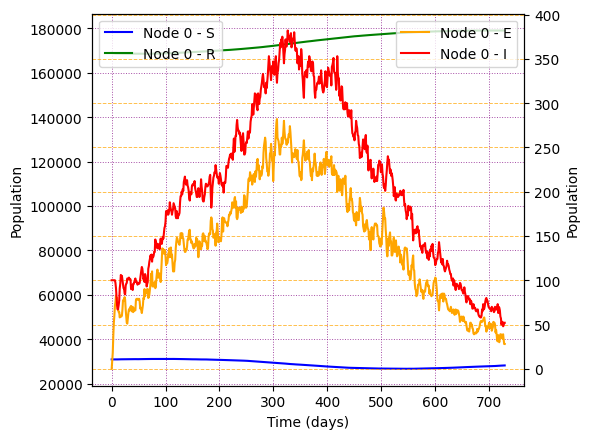

Final Susceptible:    28,263
Final Recovered:     178,988
Cumulative Infected:  14,848


In [3]:
from laser.generic import State

baseline = Model(scenario, parameters, birthrates=birthrates, name="SEIR 2 Node 2 Year No RI")
baseline.components = [
    SEIR.Susceptible(baseline),
    SEIR.Recovered(baseline),
    SEIR.Infectious(baseline, infdurdist, infdurmin=1),
    SEIR.Exposed(baseline, expdurdist, infdurdist, expdurmin=1, infdurmin=1),
    SEIR.Transmission(baseline, expdurdist=expdurdist, expdurmin=1),
    BirthsByCBR(baseline, birthrates, pyramid),
    MortalityByEstimator(baseline, survival),
]

print(f"{baseline.people.count    =:8,}")
print(f"{baseline.people.capacity =:8,}")

def initialize_susceptibility(model, output: bool = False, plot: bool = False) -> None:

    # Mark everyone over age 5 and susceptible as recovered (not susceptible)
    now = 0
    ages = now - model.people.dob

    ##### ======== #####
    if plot:
        nbins = (ages.max() + 1) // 365
        plt.hist(ages, bins=nbins, color="lightgreen", edgecolor="black")
        plt.xlabel("Age (days)")
        plt.ylabel("Count")
        plt.title("Histogram of Ages at Baseline")
        plt.show()
        print(f"Ages range from {ages.min()} to {ages.max()} days")
    ##### ======== #####

    susceptible = model.people.state == State.SUSCEPTIBLE.value
    over_five = ages >= 5*365
    susceptible_over_five = susceptible & over_five
    model.people.state[susceptible_over_five] = State.RECOVERED.value
    model.nodes.S[now,:] -= susceptible_over_five.sum()
    model.nodes.R[now,:] += susceptible_over_five.sum()
    remaining_susceptible = model.people.state == State.SUSCEPTIBLE.value
    if output:
        print(f"Initially susceptible:           {susceptible.sum():7,}")
        print(f"Initially over five:             {over_five.sum():7,}")
        print(f"Initially susceptible over five: {susceptible_over_five.sum():7,}")
        print(f"Remaining susceptible:           {remaining_susceptible.sum():7,} ({model.nodes.S[now,:].sum():7,})")

    return

initialize_susceptibility(baseline, output=True, plot=False)

baseline.run(f"SEIR {NNODES} Node(s) 2 Year No RI")

plot_traces(baseline)
print_summary(baseline)

Note that we have bumped $R_0$ up to a value which will cause an outbreak in the reduced susceptible population. $R_0 \approx N / S(0) \approx 6.5$

## Routine RI - 70% coverage, mean time to vaccination 9 months (274) days


200,000 agents in 1 node(s): 100%|██████████| 730/730 [00:01<00:00, 685.59it/s]


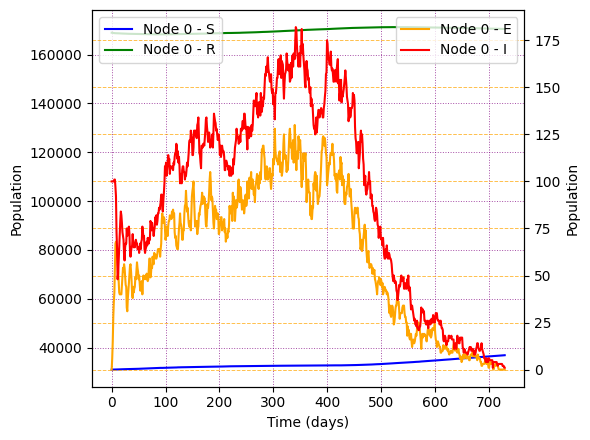

Final Susceptible:    36,869
Final Recovered:     170,451
Cumulative Infected:   6,464


In [4]:
from laser.generic.immunization import RoutineImmunizationEx

def run_with_ri(coverage_fn, dose_timing_dist=None, dose_timing_min=None, plot=True):
    with_ri = Model(scenario, parameters, birthrates=birthrates, name="SEIR 2 Node 2 Year 70% RI")

    if dose_timing_dist is None:
        dose_timing_dist = distributions.normal(loc=274, scale=15)  # Around 9 months
    if dose_timing_min is None:
        dose_timing_min = 183  # Minimum 6 months

    with_ri.components = [
        SEIR.Susceptible(with_ri),
        SEIR.Recovered(with_ri),
        SEIR.Infectious(with_ri, infdurdist, infdurmin=1),
        SEIR.Exposed(with_ri, expdurdist, infdurdist, expdurmin=1, infdurmin=1),
        SEIR.Transmission(with_ri, expdurdist=expdurdist, expdurmin=1),
        BirthsByCBR(with_ri, birthrates, pyramid),
        MortalityByEstimator(with_ri, survival),
        RoutineImmunizationEx(with_ri, coverage_fn=coverage_fn, dose_timing_dist=dose_timing_dist, dose_timing_min=dose_timing_min, track=True),
    ]

    initialize_susceptibility(with_ri, output=False)

    with_ri.run()
    if plot:
        plot_traces(with_ri)
        print_summary(with_ri)

    return with_ri

coverage_constant = distributions.constant_float(value=0.7) # 70% coverage
with_ri = run_with_ri(coverage_constant)


Note that although the shape of the outbreak resembles the shape without RI, the cumulative infected is much lower.

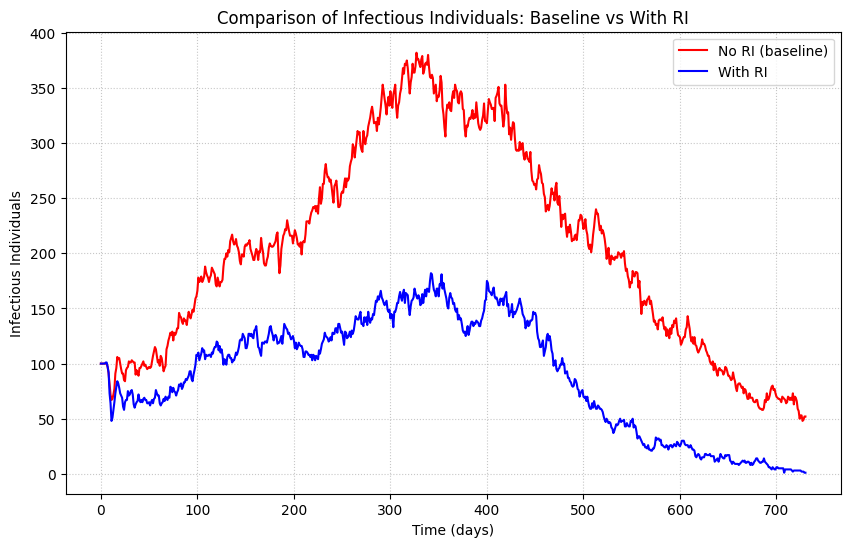

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(baseline.nodes.I[:, 0], color='red', label='No RI (baseline)')
plt.plot(with_ri.nodes.I[:, 0], color='blue', label='With RI')
plt.xlabel('Time (days)')
plt.ylabel('Infectious Individuals')
plt.title('Comparison of Infectious Individuals: Baseline vs With RI')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

We initialized the `RoutineImmunization` component with `track=True` which means we can look at the values drawn for the time-to-vaccination and plot them to verify that we are getting the values we wanted.

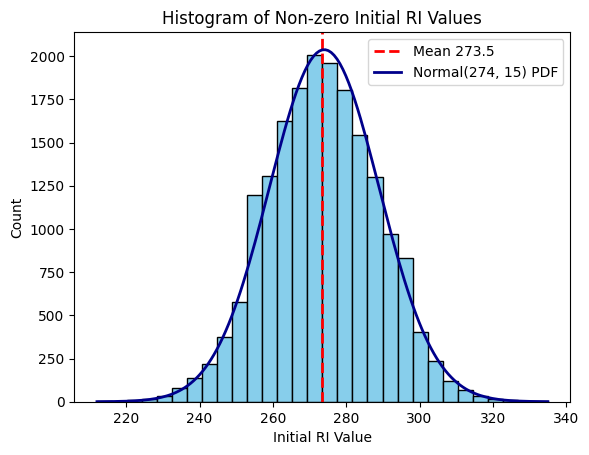

In [6]:
from scipy.stats import norm
import numpy as np

nonzero_initial_ri = with_ri.people.initial_ri[with_ri.people.initial_ri > 0]

counts, bins, _ = plt.hist(nonzero_initial_ri, bins=30, color="skyblue", edgecolor="black")

# Mark the mean initial RI value
plt.axvline(nonzero_initial_ri.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean {nonzero_initial_ri.mean():.1f}")

x = np.linspace(bins[0], bins[-1], len(bins)*5) # *5 for smoothness
pdf = norm.pdf(x, loc=274, scale=15)
# Scale the PDF so that its maximum matches the maximum of the histogram
bin_width = bins[1] - bins[0]
pdf_scaled = pdf * nonzero_initial_ri.size * bin_width
plt.plot(x, pdf_scaled, color="darkblue", linewidth=2, label="Normal(274, 15) PDF")

plt.legend()
plt.xlabel('Initial RI Value')
plt.ylabel('Count')
plt.title('Histogram of Non-zero Initial RI Values')
plt.show()